In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import copy

In [2]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [3]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2, RUN)), allow_pickle=True)
encoded_train_AE2, encoded_valid_AE2, encoded_test_AE2 = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2, RUN)), allow_pickle=True)
decoded_train,decoded_valid, decoded_test, mean, std = np.load(os.path.join(root_decoded,'decoded_%s.npy'%(label_2)), allow_pickle=True)

In [4]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))

In [5]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [6]:
decoded_2 = {}
encoded_2 = {}

In [7]:
encoded_train_2 = encoder(decoded_train)
decoded_2['train'] = decoder(encoded_train_2).numpy()

encoded_valid_2 = encoder(decoded_valid)
decoded_2['valid'] = decoder(encoded_valid_2).numpy()

encoded_test_2 = encoder(decoded_test)
decoded_2['test'] = decoder(encoded_test_2).numpy()

In [8]:
for tag, data in zip(['train','valid', 'test'],[encoded_train_2,encoded_valid_2,encoded_test_2]):
    encoded_2[tag] = data.numpy()

In [9]:
def inpaint(orig,recon,mask):
    inpaint = copy.copy(orig)
    inpaint[mask] = np.expand_dims(recon,-1)[mask]
    return inpaint

In [10]:
decoded_new = {}

for tag, data in zip(['valid','train','test'],[valid,train,test]):
    decoded_new[tag] = inpaint(data['spec'],decoded_2[tag],data['mask'].astype(bool))

In [11]:
encoded_new = {}
for tag in ['valid','train','test']:
    encoded_new[tag]=encoder(decoded_new[tag]).numpy()

In [12]:
encoded_new.keys()

dict_keys(['valid', 'train', 'test'])

In [13]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)),[np.squeeze(encoded_new['train']), np.squeeze(encoded_new['valid']), np.squeeze(encoded_new['test'])])
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)),[np.squeeze(decoded_new['train']),np.squeeze(decoded_new['valid']), np.squeeze(decoded_new['test'])])

In [14]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s_2.npy'%(label_2,RUN)),[np.squeeze(encoded_2['train']), np.squeeze(encoded_2['valid']), np.squeeze(encoded_2['test'])])
np.save(os.path.join(root_decoded,'decoded_%s_RUN%s_2.npy'%(label_2,RUN)),[np.squeeze(decoded_2['train']),np.squeeze(decoded_2['valid']), np.squeeze(decoded_2['test'])])

In [14]:
latent_dim =10 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


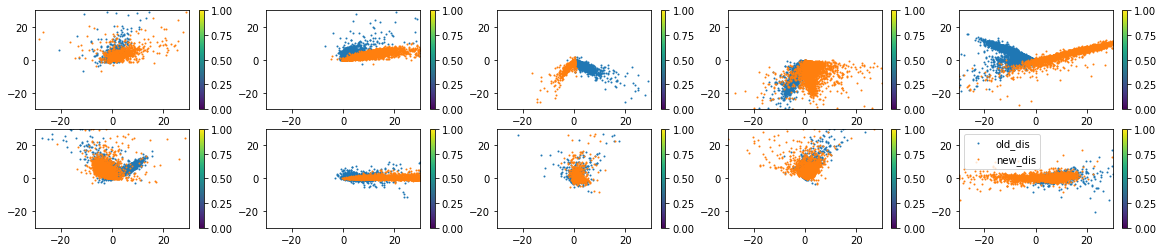

In [17]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:10000,ii],encoded_train[:10000,jj], cmap='nipy_spectral',s=1, label='old_dis')
    #im = ax[ii].scatter(encoded_train_2[:10000,ii],encoded_train_2[:10000,jj], cmap='nipy_spectral',s=1)
    #im = ax[ii].scatter(encoded_new['train'][:10000,ii],encoded_train_2[:10000,jj], cmap='nipy_spectral',s=1)
    im = ax[ii].scatter(encoded_train_AE2[:10000,ii],encoded_train[:10000,jj], cmap='nipy_spectral',s=1, label='new_dis')

    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
    plt.legend()
plt.show()

In [24]:
dist = np.sqrt(np.sum((encoded_train-np.squeeze(encoded_train_AE2))**2,axis=(1)))

In [25]:
ind = np.argsort(dist)[::-1]

In [26]:
dist[ind]

array([9.7386945e+02, 6.5394940e+02, 6.3351447e+02, ..., 8.6722404e-01,
       7.8716564e-01, 6.8720955e-01], dtype=float32)

biggest jump spectra


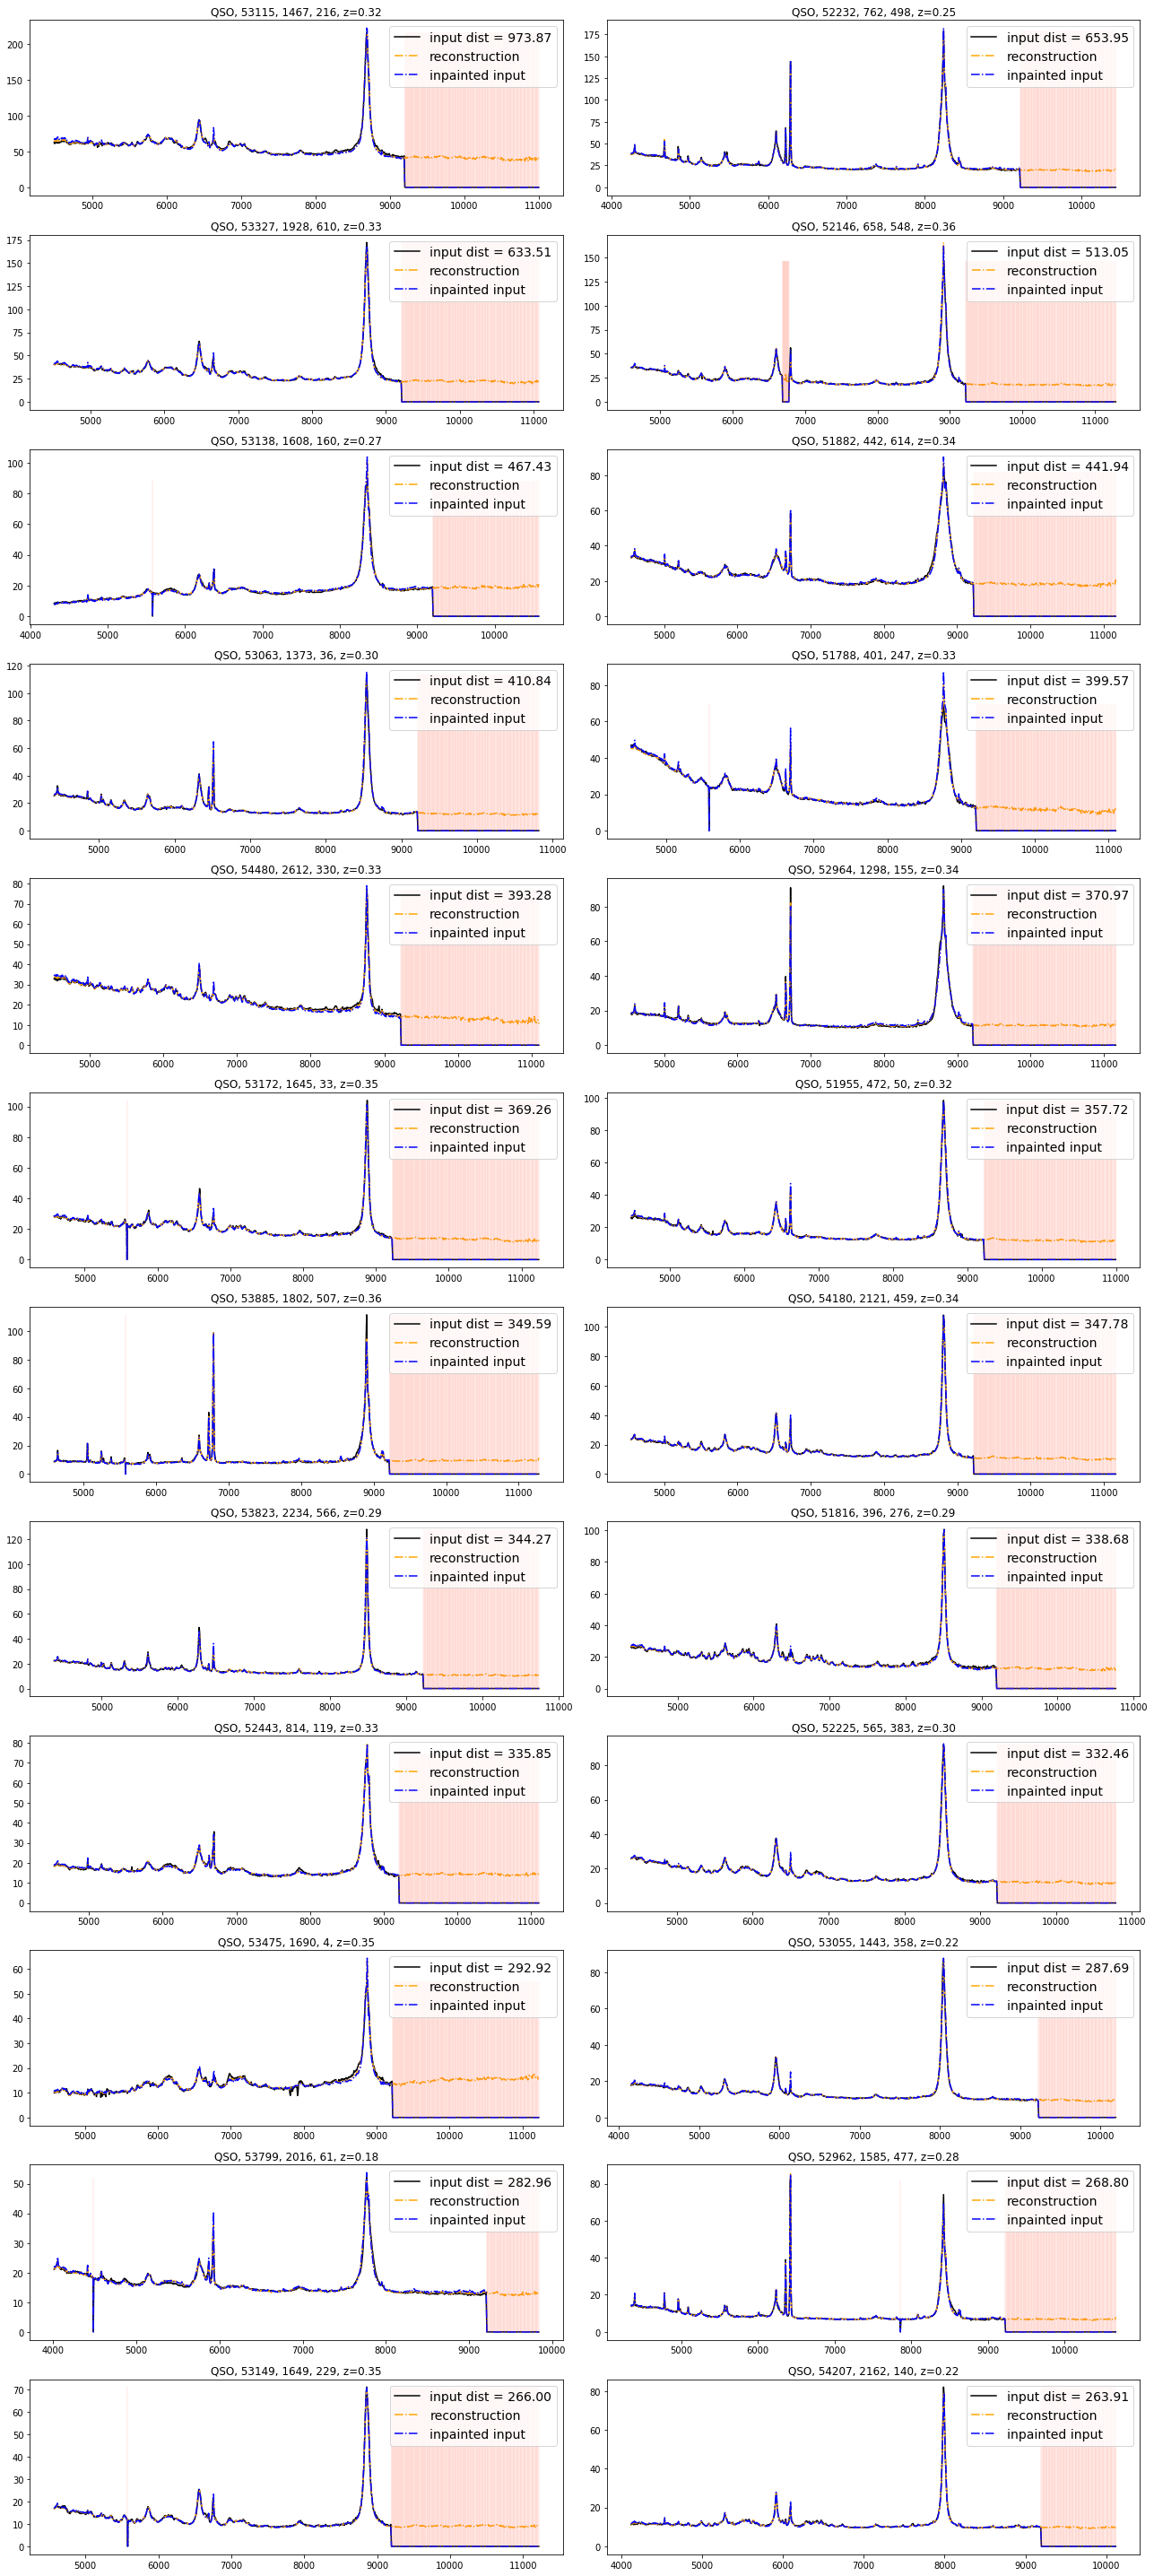

In [27]:

classes = {2:'GAL', 1:'QSO', 0:'STAR'}


outliers_decoded  = decoded_train[ind]

outliers_decoded_2  = decoded_new['train'][ind]
outliers_input    = train['spec'][ind]

wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


print('biggest jump spectra')
fi, ax = plt.subplots(12,2,figsize=(18,40))
ax = ax.flatten()
for ii in range(24):
    ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[train['class'][ind][ii]], train['MJD'][ind][ii],train['plate'][ind][ii],train['fiber'][ind][ii],train['z'][ind][ii]))
    ax[ii].plot(new_wl[1:]*(train['z'][ind][ii]+1),outliers_input[ii],label='input dist = %.2f'%(dist[ind][ii]), color='black')
    ax[ii].plot(new_wl[1:]*(train['z'][ind][ii]+1),outliers_decoded[ii], label='reconstruction',ls='-.', color='orange')
    ax[ii].plot(new_wl[1:]*(train['z'][ind][ii]+1),outliers_decoded_2[ii], label='inpainted input',ls='-.', color='blue')
    ax[ii].vlines( x=new_wl[1:][np.squeeze(~train['mask'][ind][ii].astype(bool))]*(1+train['z'][ind][ii]), ymin=0,ymax=max(train['spec'][ind][ii]), color='tomato',alpha=0.1,zorder=4)

    ax[ii].legend(fontsize=14)
plt.tight_layout()

